In [1]:
import obspy
import seisbench
import seisbench.models as sbm
import pandas as pd
import pickle

from __future__ import print_function
import numpy as np
import h5py
import glob
import math
import os
import shutil
from scipy import signal
from scipy.signal import butter, lfilter
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv1D, MaxPooling1D, UpSampling1D, Flatten, Dropout, Reshape 
from keras.layers import Bidirectional, BatchNormalization, ZeroPadding1D, Conv2DTranspose
from keras.models import Model
from keras import backend as K
from tensorflow.keras.optimizers import SGD, Adam
from keras import regularizers
from tensorflow.keras.layers import Layer, InputSpec
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, EarlyStopping
from keras.initializers import VarianceScaling
from keras.callbacks import CSVLogger
from scipy.optimize import linear_sum_assignment as linear_assignment
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import metrics
import matplotlib.pyplot as plt
from matplotlib.pyplot import savefig

#import seaborn as sns # seaborn import line is erroring
#sns.set_style('darkgrid')
#sns.set_palette('muted')

2022-03-17 12:35:01.603822: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-17 12:35:01.603863: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
def Store_Models(path, obj):
    db_file = open(path, 'wb')
    
    pickle.dump(obj, db_file)                     
    db_file.close()
    
    return 'Successfully stored pickles!'

def Load_Models_Pickle(path):
    db_file = open(path, 'rb')
    models = pickle.load(db_file)
    
    return models

### Load Data

In [3]:
east_channel_path     = '/global/scratch/users/taira/mleq/mseed/1001.HF.EPE.00.2020.342'
north_channel_path    = '/global/scratch/users/taira/mleq/mseed/1001.HF.EPN.00.2020.342'
vertical_channel_path = '/global/scratch/users/taira/mleq/mseed/1001.HF.EPZ.00.2020.342'

stream = obspy.read(east_channel_path)
stream += obspy.read(north_channel_path)
stream += obspy.read(vertical_channel_path)

stream_arr = [list(stream[i].data) for i in range(3)]

In [4]:
# intermediate data batching 

stream_arr_by_time = [[[stream_arr[0][i]], [stream_arr[1][i]], [stream_arr[2][i]]] for i in range(len(stream_arr[0]))]
step_size = 16
batched_stream_arr_by_time = [stream_arr_by_time[i:i + step_size] for i in range(0, len(stream_arr_by_time), step_size)]

In [5]:
os.environ['CUDA_VISIBLE_DEVICES'] = ""
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7717963294000565447
xla_global_id: -1
]


2022-03-17 12:36:14.088950: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-03-17 12:36:14.089010: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (n0105.savio1): /proc/driver/nvidia/version does not exist


In [11]:
inp = Input(shape=(step_size,3,1))  
e = Conv2D(4, (3, 3), activation='tanh', padding='same')(inp)
e = MaxPooling2D((2, 3), padding='same')(e)
e = Conv2D(2, (3, 3), activation='tanh', padding='same')(e)
e = MaxPooling2D((2, 1), padding='same')(e)
e = Conv2D(1, (3, 3), activation='tanh', padding='same')(e)
e = MaxPooling2D((2, 1), padding='same')(e)

shape_before_flattening = K.int_shape(e)
encoded = Flatten()(e)
d = Reshape(shape_before_flattening[1:])(encoded)

d = Conv2D(1, (3, 3), activation='tanh', padding='same')(d)
d = UpSampling2D((2, 1))(d)
d = Conv2D(2, (3, 3), activation='tanh', padding='same')(d)
d = UpSampling2D((2, 1))(d)
d = Conv2D(4, (3, 3), activation='tanh', padding='same')(d)
d = UpSampling2D((2, 3))(d)
decoded = Conv2D(1, (3, 3), padding='same')(d)

autoencoder = Model(inputs=inp, outputs=decoded, name='autoencoder')
encoder = Model(inputs=inp, outputs=encoded, name='encoder')

# # from keras.utils import plot_model
# # from keras.utils.vis_utils import plot_model
# # plot_model(autoencoder, to_file='autoencoder.png', show_shapes=True)
# # from IPython.display import Image
# # Image(filename='autoencoder.png')

autoencoder.compile(optimizer='adam', loss='mse')
csv_logger = CSVLogger('pretrain_log.csv')

autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 16, 3, 1)]        0         
                                                                 
 conv2d_35 (Conv2D)          (None, 16, 3, 4)          40        
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 8, 1, 4)          0         
 g2D)                                                            
                                                                 
 conv2d_36 (Conv2D)          (None, 8, 1, 2)           74        
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 4, 1, 2)          0         
 g2D)                                                            
                                                                 
 conv2d_37 (Conv2D)          (None, 4, 1, 1)           

In [12]:
## only need to rerun if changing data ##
## currently stored in saved_models/clustering_autoencoder_pickle ###

autoencoder.fit(batched_stream_arr_by_time, batched_stream_arr_by_time, batch_size=128, epochs=30, callbacks=[csv_logger])
# Store_Models('saved_models/clustering_v2_autoencoder_pickle', autoencoder)

Epoch 1/30
4219/4219 [==============================] - 27s 6ms/step - loss: 0.0021
Epoch 2/30
4219/4219 [==============================] - 25s 6ms/step - loss: 0.0020
Epoch 3/30
4219/4219 [==============================] - 26s 6ms/step - loss: 0.0020
Epoch 4/30
4219/4219 [==============================] - 26s 6ms/step - loss: 0.0020
Epoch 5/30
4219/4219 [==============================] - 26s 6ms/step - loss: 0.0020
Epoch 6/30
4219/4219 [==============================] - 24s 6ms/step - loss: 0.0020
Epoch 7/30
4219/4219 [==============================] - 24s 6ms/step - loss: 0.0020
Epoch 8/30
4219/4219 [==============================] - 24s 6ms/step - loss: 0.0020
Epoch 9/30
4219/4219 [==============================] - 24s 6ms/step - loss: 0.0020
Epoch 10/30
4219/4219 [==============================] - 24s 6ms/step - loss: 0.0020
Epoch 11/30
4219/4219 [==============================] - 24s 6ms/step - loss: 0.0020
Epoch 12/30
4219/4219 [==============================] - 24s 6ms/step - lo

In [13]:
Store_Models('saved_models/clustering_v2_autoencoder_pickle', autoencoder)

2022-03-17 12:57:15.675746: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ram://8fb1c709-b3ba-4777-b507-daaac6231335/assets


'Successfully stored pickles!'

In [ ]:
# autoencoder = Load_Models_Pickle('saved_models/clustering_v2_autoencoder_pickle')

In [14]:
class ClusteringLayer(Layer):
    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(shape=(self.n_clusters, input_dim), initializer='glorot_uniform', name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1)) 
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))
    
print('...Finetuning...')
n_clusters = 2
clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)
model = Model(inputs=[encoder.input], outputs=[clustering_layer, encoder.output])
model.compile(loss=['kld', 'mse'], loss_weights=[0.1, 1], optimizer='adam')

# from keras.utils import plot_model
# plot_model(model, to_file='model.png', show_shapes=True)
# from IPython.display import Image
# Image(filename='model.png')

...Finetuning...


In [15]:
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred = kmeans.fit_predict(encoder.predict(batched_stream_arr_by_time))
y_pred_last = np.copy(y_pred)
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])

In [ ]:
# Store_Models('saved_models/y_pred_clustering_v2', y_pred)
# y_pred = Load_Models_Pickle('saved_models/y_pred_clustering_v2')

In [17]:
def plot_waves(stream, predictions):
    fig = plt.figure(figsize=(16, 10))
    axs = fig.subplots(3, 1, sharex=True, sharey=True, gridspec_kw={'hspace': 0})
                
    df = pd.DataFrame({'E': stream[0].data, 'N': stream[1].data, 'Z': stream[2].data})
    step_size = 16
    df['y_pred'] = np.repeat(y_pred, step_size)
    
    zero = df[df['y_pred'] == 0]
    one = df[df['y_pred'] == 1]

    for i in range(3):
        axs[0].plot(df.index, df.iloc[:, i], label=df.columns[i])
        axs[1].plot(zero.index, zero.iloc[:, i], label=df.columns[i])
        axs[2].plot(one.index, one.iloc[:, i], label=df.columns[i])
    
    axs[0].legend()
    axs[1].legend()
    axs[2].legend()
    
    axs[0].title.set_text("Stream")
    axs[1].title.set_text('Cluster 0')
    axs[2].title.set_text('Cluster 1')
    plt.show()
    return 0

ERROR! Session/line number was not unique in database. History logging moved to new session 148


In [19]:
y_pred

array([1, 1, 1, ..., 1, 1, 1], dtype=int32)

In [20]:
len(y_pred)

540000

In [22]:
len(y_pred) * 16

8640000

In [23]:
8640000 / 24 

360000.0

In [24]:
360000 / 60

6000.0

In [25]:
6000 / 60

100.0

In [26]:
stream[0].stats

         network: HF
         station: 1001
        location: 00
         channel: EPE
       starttime: 2020-12-07T00:00:04.366000Z
         endtime: 2020-12-08T00:00:04.362592Z
   sampling_rate: 99.99999237060547
           delta: 0.010000000762939512
            npts: 8640000
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'D', 'number_of_records': 17212, 'encoding': 'FLOAT64', 'byteorder': '>', 'record_length': 4096, 'filesize': 70500352})

## Make sure pipeline is debugged

#### increase window length from 16; 10 second long window maybe better? try to increase clusters next week too
#### 

#### 10 second = 1000 units, play aorund with window length and num clusters
#### stream[0].stats --> trace metadata


#### look into if we can test this clustering algorithm / structure (sin wave + noise), multiple sin waves summed

#### try wavelet transform / short-time fourier transform

#### https://github.com/stanford-futuredata/FAST

https://www.science.org/doi/10.1126/sciadv.1501057

In [21]:
sum(y_pred)

273247

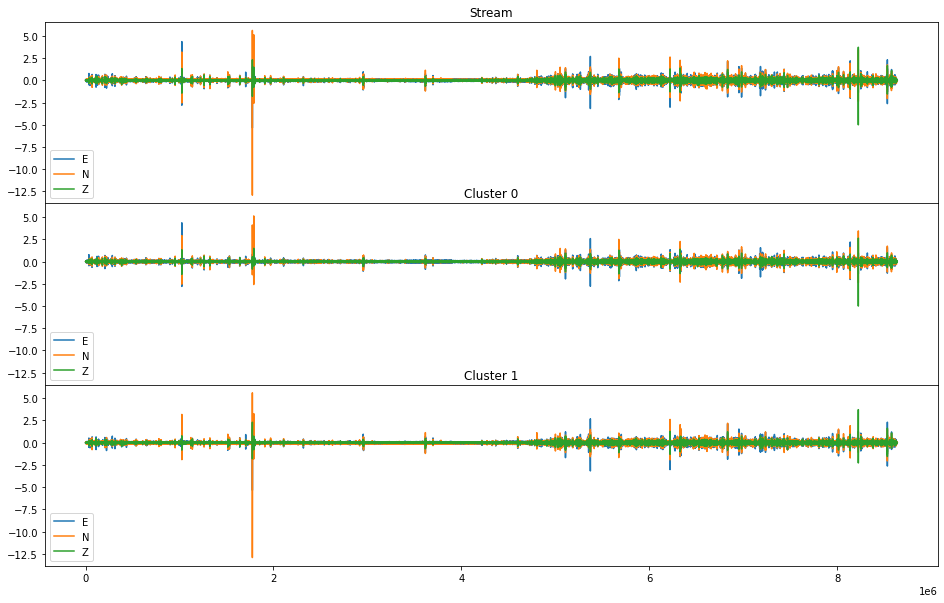

0

In [18]:
plot_waves(stream, y_pred)